# Project: Ham vs. Spam (Text Classification)

## Overview
In this project you will build a machine learning model that predicts whether a text message is **ham** (normal) or **spam** (unwanted/advertising/scam). This is one of the most common “real world” classification problems and is a great way to practice the full data science workflow.

You will work with a labeled dataset of SMS messages and train a model using features created from text (for example: **bag-of-words** or **TF–IDF**).

## Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import unicodedata

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def clean_text(text):
    text = text.lower()                                                        #lowercase
    text = re.sub(r'(^|\W)\d+($|\W)', ' ', text)                               #strip numbers, retain words with numbers, ex 1st, h8
    text = re.sub(r'[\(\)\.\?\!\\/<>\$\%\"]', ' ', text)                       #strip ().?!\/<>$%"
    text = re.sub(r'\&\w+\;', ' ', text)                                       #strip html chars ex. &nbsp;
    text = re.sub(r'[&]', 'and', text)                                         #strip &
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')                                             #convert accent/unicode chars to ascii
    text = text.strip()                                                        #strip whitespace
    return text

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Need to understand missing values on Unamed columns.
# Wiew rows with data populated in Unnamed cols
df.dropna(how='all', subset=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']).head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [6]:
# View raw text for a sample row 95 and neighbors

with open('spam.csv', "r", encoding='latin-1') as f:
    i = 0
    for line in f:
        if i in [0, 94, 95, 96]:
            print(line)
        i += 1

v1,v2,,,

spam,Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,,,

ham,Havent planning to buy later. I check already lido only got 530 show in e afternoon. U finish work already?,,,

spam,"Your free ringtone is waiting to be collected. Simply text the password \MIX\"" to 85069 to verify. Get Usher and Britney. FML", PO Box 5249," MK17 92H. 450Ppw 16""",



In [7]:
# Looks like \n or quotes were not handled correctly when the data was ingested.
# I will use the default csv import and merge these columns back into v2, rather than a custom csv import

df = df.fillna(' ')
df['v2'] = df['v2'] + df['Unnamed: 2'] + df['Unnamed: 3'] + df['Unnamed: 4']
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df['v2'] = df['v2'].str.strip()
df.columns=['label', 'text']

In [8]:
# Clean Text, generate stats
df['text_cln'] = df['text'].map(clean_text).map(clean_text)

df['org_length'] = df['text'].str.len()
df['org_word_count'] = df['text'].map(lambda x: len(x.split(' ')))

df['clean_length'] = df['text_cln'].str.len()
df['clean_word_count'] = df['text_cln'].map(lambda x: len(x.split(' ')))

df['fraction_cleaned'] = ( df['org_length'] - df['clean_length'] ) / df['org_length']

# Convert text labels to bool target
df['target'] = df['label'].map({'ham':0, 'spam':1})

## EDA Summary

In [9]:
print('Columns, data types, missing values')
print('---------------------------\n')
df.info()

Columns, data types, missing values
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             5572 non-null   object 
 1   text              5572 non-null   object 
 2   text_cln          5572 non-null   object 
 3   org_length        5572 non-null   int64  
 4   org_word_count    5572 non-null   int64  
 5   clean_length      5572 non-null   int64  
 6   clean_word_count  5572 non-null   int64  
 7   fraction_cleaned  5572 non-null   float64
 8   target            5572 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 391.9+ KB


In [10]:
print('Table dimensions')
print('---------------------------\n')
print(df.shape)
print('\n\nLabel Counts')
print('---------------------------\n')
summary = df['label'].value_counts().reset_index()
summary['percent'] = round(100 * summary['count'] / df.shape[0],1)
summary

Table dimensions
---------------------------

(5572, 9)


Label Counts
---------------------------



,label,count,percent
0,ham,4825,86.6
1,spam,747,13.4


In [11]:
print('\nHam Sample Texts (Cleaned)')
print('---------------------------\n')
ham_sample = df[df['label'] == 'ham']['text_cln'].sample(5).to_list()
print('•', '\n\n• '.join(ham_sample))


Ham Sample Texts (Cleaned)
---------------------------

• i'm in a movie    collect car oredi

• i can't keep going through this  it was never my intention to run you out, but if you choose to do that rather than keep the room clean so *i* don't have to say no to visitors, then maybe that's the best choice  yes, i wanted you to be embarassed, so maybe you'd feel for once how i feel when i have a friend who wants to drop buy and i have to say no, as happened this morning  i've tried everything  i don't know what else to do

• pls help me tell sura that i'm expecting a battery from hont  and that if should pls send me a message about how to download movies  thanks

• the affidavit says   #   e twiggs st, division g, courtroom   #  ,  time   am  i'll double check and text you again tomorrow

• my supervisor find me one lor i thk his students  i havent ask her yet  tell u aft i ask her


In [12]:
print('\nSpam Sample Texts (Cleaned)')
print('---------------------------\n')
spam_sample = df[df['label'] == 'spam']['text_cln'].sample(5).to_list()
print('•', '\n\n• '.join(spam_sample))


Spam Sample Texts (Cleaned)
---------------------------

• private  your account statement for shows un-redeemed s  i  m  points  call identifier code: expires

• want to funk up ur fone with a weekly new tone reply tones2u this text  www ringtones co uk, the original n best  tones 3gbp network operator rates apply

• thanks for your ringtone order, ref number r836  your mobile will be charged a  should your tone not arrive please call customer services on

• a uk break accommodationvouchers terms and conditions apply  claim you mustprovide your claim number which is

• spook up your mob with a halloween collection of a logo and pic message plus a free eerie tone, txt card spook to zed 08701417012150p per logo pic


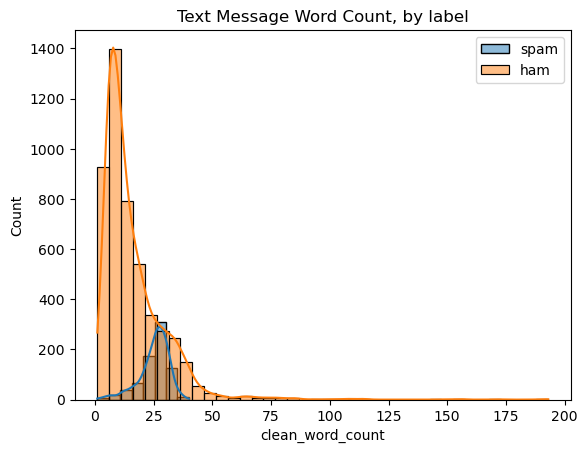

In [13]:
sns.histplot(data=df[df['label'] == 'spam'], label='spam', x='clean_word_count', kde=True, binwidth=5)
sns.histplot(data=df[df['label'] == 'ham'], label='ham',  x='clean_word_count', kde=True, binwidth=5)
plt.legend()
plt.title('Text Message Word Count, by label')
plt.show()

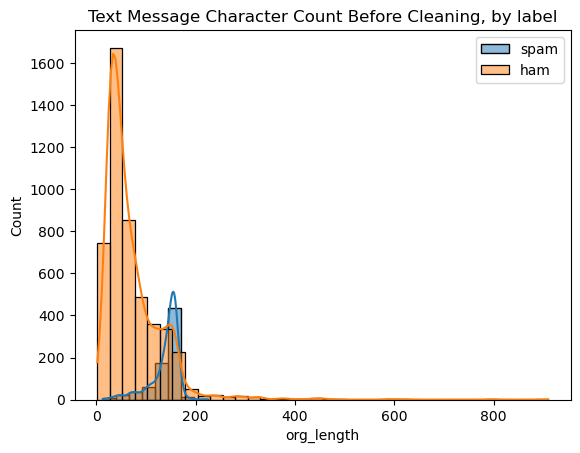

In [14]:
sns.histplot(data=df[df['label'] == 'spam'], label='spam', x='org_length', kde=True, binwidth=25)
sns.histplot(data=df[df['label'] == 'ham'], label='ham',  x='org_length', kde=True, binwidth=25)
plt.legend()
plt.title('Text Message Character Count Before Cleaning, by label')
plt.show()

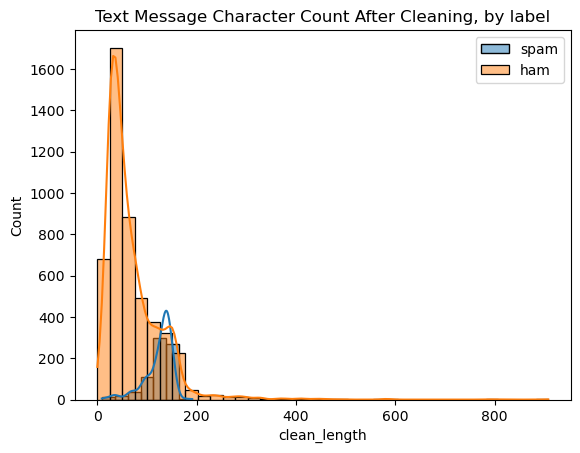

In [15]:
sns.histplot(data=df[df['label'] == 'spam'], label='spam', x='clean_length', kde=True, binwidth=25)
sns.histplot(data=df[df['label'] == 'ham'], label='ham',  x='clean_length', kde=True, binwidth=25)
plt.legend()
plt.title('Text Message Character Count After Cleaning, by label')
plt.show()

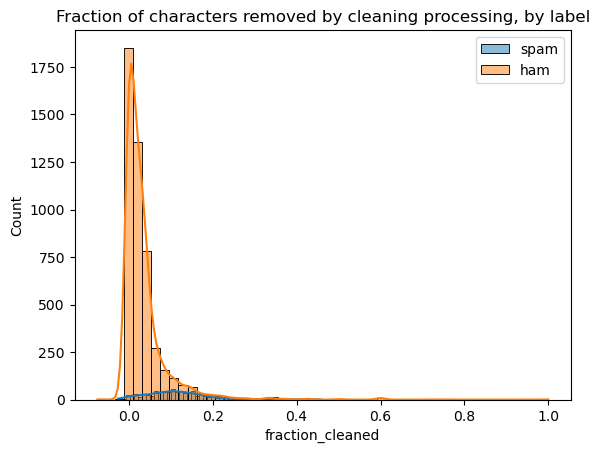

In [16]:
sns.histplot(data=df[df['label'] == 'spam'], label='spam', x='fraction_cleaned', kde=True, bins=50)
sns.histplot(data=df[df['label'] == 'ham'], label='ham',  x='fraction_cleaned', kde=True, bins=50)
plt.legend()
plt.title('Fraction of characters removed by cleaning processing, by label')
plt.show()

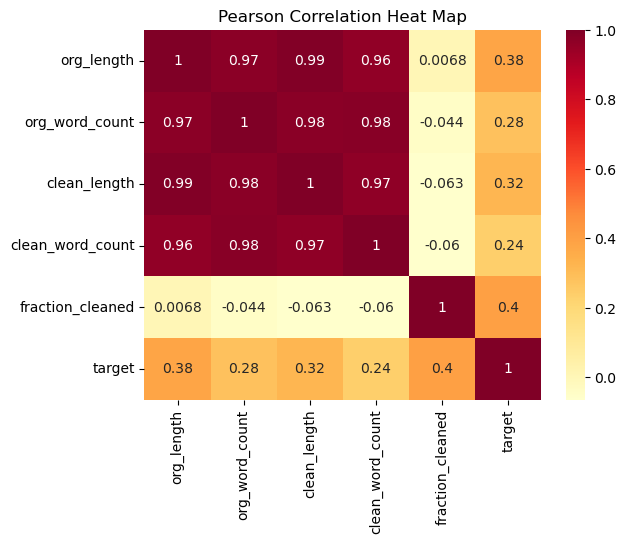

In [17]:
# Pearson correlation as heat map
sns.heatmap(df.corr(numeric_only=True), cmap="YlOrRd", annot=True)
plt.title('Pearson Correlation Heat Map')
plt.show()

In [59]:
print('\nDecriptive Stats - Corpus')
print('---------------------------\n')
display(df.describe().filter(items=['mean', 'std', 'min', 'max'], axis=0))

print('\nDecriptive Stats - Ham only')
print('---------------------------\n')
display(df[df['label'] == 'ham'].describe().filter(items=['mean', 'std', 'min', 'max'], axis=0))

print('\nDecriptive Stats - Spam only')
print('---------------------------\n')
display(df[df['label'] == 'spam'].describe().filter(items=['mean', 'std', 'min', 'max'], axis=0))


Decriptive Stats - Corpus
---------------------------



,org_length,org_word_count,clean_length,clean_word_count,fraction_cleaned,target
mean,80.645190,15.673546,77.020639,17.347452,0.044609,0.134063
std,59.986353,11.478396,57.412418,13.201661,0.066082,0.340751
min,2.000000,1.000000,0.000000,1.000000,-0.075472,0.000000
max,910.000000,171.000000,908.000000,193.000000,1.000000,1.000000



Decriptive Stats - Ham only
---------------------------



,org_length,org_word_count,clean_length,clean_word_count,fraction_cleaned,target
mean,71.594197,14.398135,69.735544,16.120415,0.034252,0.0
std,58.435287,11.612616,57.345214,13.558538,0.058555,0.0
min,2.000000,1.000000,0.000000,1.000000,-0.075472,0.0
max,910.000000,171.000000,908.000000,193.000000,1.000000,0.0



Decriptive Stats - Spam only
---------------------------



,org_length,org_word_count,clean_length,clean_word_count,fraction_cleaned,target
mean,139.107095,23.911647,124.076305,25.273092,0.111507,1.0
std,28.960763,5.780174,28.107050,6.334328,0.072553,0.0
min,13.000000,2.000000,9.000000,1.000000,-0.026316,1.0
max,224.000000,35.000000,191.000000,40.000000,0.457143,1.0


In [19]:
# Use vectorize on full corpus to find top words

vectorizer = CountVectorizer(stop_words='english')

corpus_vec_output = vectorizer.fit_transform(df['text_cln'])

corpus_vec_df = pd.DataFrame(vectorizer.fit_transform(df['text_cln']).toarray(), columns=vectorizer.get_feature_names_out())

corpus_top_words = corpus_vec_df.sum().sort_values(ascending=False) / df.shape[0]
corpus_top_words = corpus_top_words.reset_index().reset_index()
corpus_top_words.columns = ['rank in corpus', 'word', 'frequency in corpus']
corpus_top_words['rank in corpus'] += 1

print('\nTop 20 Words in corpus after cleaning and stop words removed')
print('(occurence/message)')
print('---------------------------\n')
corpus_top_words.head(20).style.hide().format(precision=3)


Top 20 Words in corpus after cleaning and stop words removed
(occurence/message)
---------------------------



rank in corpus,word,frequency in corpus
1,ur,0.070
2,just,0.067
3,ok,0.053
4,free,0.051
5,ll,0.047
6,know,0.047
7,good,0.044
8,like,0.044
9,got,0.043
10,come,0.042


In [20]:
# Use vectorize ham subset

vectorizer = CountVectorizer(stop_words='english')

ham_vec_output = vectorizer.fit_transform(df['text_cln'][df['label'] == 'ham'])

ham_vec_df = pd.DataFrame(ham_vec_output.toarray(), columns=vectorizer.get_feature_names_out())

ham_top_words = ham_vec_df.sum().sort_values(ascending=False) / df[df['label'] == 'ham'].shape[0]
ham_top_words = ham_top_words.reset_index().reset_index()
ham_top_words.columns = ['rank in ham subset', 'word', 'frequency in ham subset']
ham_top_words['rank in ham subset'] += 1

# Use vectorize spam subset

vectorizer = CountVectorizer(stop_words='english')

spam_vec_output = vectorizer.fit_transform(df['text_cln'][df['label'] == 'spam'])

spam_vec_df = pd.DataFrame(spam_vec_output.toarray(), columns=vectorizer.get_feature_names_out())

spam_top_words = spam_vec_df.sum().sort_values(ascending=False) / df[df['label'] == 'spam'].shape[0]
spam_top_words = spam_top_words.reset_index().reset_index()
spam_top_words.columns = ['rank in spam subset', 'word', 'frequency in spam subset']
spam_top_words['rank in spam subset'] += 1

In [60]:
# Join corpus and ham stats to spam top words dataframe

merge_df = pd.merge(spam_top_words, ham_top_words, on='word', how='left')
merge_df = pd.merge(merge_df, corpus_top_words, on='word', how='left')
merge_df['spam/ham'] = merge_df['frequency in spam subset'] / merge_df['frequency in ham subset']

def highlight_row(row):
    color = 'color: red' if row['rank in spam subset'] > row['rank in corpus'] else ''
    return [color] * len(row)

print('\nTop 20 Words - Spam messages (occurence/message)')
print('Red text indicates spam rank is lower than overall corpus rank')
print('---------------------------\n')
merge_df.head(20).style.hide().format(precision=3)\
    .format(precision=0, subset=['rank in ham subset'])\
    .apply(highlight_row, axis=1)


Top 20 Words - Spam messages (occurence/message)
Red text indicates spam rank is lower than overall corpus rank
---------------------------



rank in spam subset,word,frequency in spam subset,rank in ham subset,frequency in ham subset,rank in corpus,frequency in corpus,spam/ham
1,free,0.300,79,0.012,4,0.051,24.114
2,txt,0.218,441,0.003,17,0.032,75.203
3,ur,0.193,4,0.051,1,0.070,3.766
4,mobile,0.170,417,0.003,29,0.025,54.688
5,text,0.167,64,0.014,16,0.035,11.873
6,stop,0.165,141,0.008,23,0.029,21.472
7,claim,0.151,nan,nan,45,0.020,nan
8,reply,0.139,116,0.009,28,0.027,15.267
9,www,0.131,2449,0.000,54,0.018,316.499
10,prize,0.124,nan,nan,61,0.017,nan


In [22]:
print('\nTop 50 Words occuring in Spam messages only')
print('---------------------------\n')
print(' '.join(merge_df[merge_df['rank in ham subset'].isna()].head(50)['word'].to_list()))


Top 50 Words occuring in Spam messages only
---------------------------

claim prize 150p tone guaranteed awarded 150ppm ringtone entry tones collection mob valid tandc weekly 10p tandcs national vouchers bonus sae http poly unsubscribe land 12hrs expires opt dating mobileupd8 identifier winner pobox camcorder quiz 2lands operator suite342 freemsg costa wkly savamob txts call2optout complimentary charged mobiles ac ipod redeemed


In [23]:
print('\nWords with spam frequency to ham frequency ratio greater than 100x')
print('---------------------------\n')
print(' '.join(merge_df[merge_df['spam/ham'] > 100].sort_values('spam/ham', ascending=False)['word'].to_list()))


Words with spam frequency to ham frequency ratio greater than 100x
---------------------------

uk www code award nokia delivery club await games private services video landline statement voucher


## Takeaways

- The dataset appears to originate from the UK. These text messages contain a high amount of vernacular and shorthands that will generate noise columns in vectorization and evade stopwords.
- The data set contains ~5500 entries with 13.4% marked as spam.
- Average message length (before cleaning) for spam is nearly double of ham messages, 139 vs. 72.
- Average word counts after cleaning were 25 vs. 16.
- The top 5 words in the spam dataset were: free, txt, ur, mobile, text.
- Ratio of word occurence in spam messages vs. ham messages was measured. These words exceed 100x occurence in spam messages:
    - uk www code award nokia delivery club await games private services video landline statement voucher